In [2]:
import os
os.environ["MUJOCO_GL"] = "egl"
os.environ["TDMPC_PATH"] = "/home/ksrini/multi_task_experts/collect_myosuite/tdmpc2"
from common.parser import parse_cfg
from common.seed import set_seed
from envs import make_env
from envs.myosuite import MYOSUITE_TASKS
from tdmpc2 import TDMPC2
from pathlib import Path
from omegaconf import OmegaConf

import robomimic
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
from robomimic.envs.env_base import EnvBase
from robomimic.algo import RolloutPolicy

import h5py
import json
import hydra
import numpy as np
import myosuite
import matplotlib.pyplot as plt
import torch
import myosuite
from copy import deepcopy
from pathlib import Path

/home/ksrini/.pyenv/versions/miniconda3-latest/envs/robomimic/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ksrini/.pyenv/versions/miniconda3-latest/envs/robomimic/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/ksrini/multi_task_experts/robomimic/robomimic/scripts/setup_macros.py
)


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/robomimic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MyoSuite:> Registering Myo Envs


In [2]:
task_keys = list(MYOSUITE_TASKS.keys())
task_keys

['myo-reach',
 'myo-reach-hard',
 'myo-pose',
 'myo-pose-hard',
 'myo-obj-hold',
 'myo-obj-hold-hard',
 'myo-key-turn',
 'myo-key-turn-hard',
 'myo-pen-twirl',
 'myo-pen-twirl-hard']

## Add env args to dataset

In [2]:
ckpt_dir = Path("/home/ksrini/multi_task_experts/collect_myosuite/tdmpc2_ckpts/myosuite")
data_dir = Path("/home/ksrini/multi_task_experts/datasets/")
for task in list(MYOSUITE_TASKS.keys()):
    task_name = "-".join([task.split("-")[0], "hand"] + task.split("-")[1:])
    ckpt = ckpt_dir / f"{task_name}-1.pt" 
    overrides = ["hydra/launcher=basic"]
    overrides.append(f"task={task}")
    overrides.append(f"checkpoint={str(ckpt.resolve())}")

    with hydra.initialize():
        cfg = hydra.compose("config.yaml", overrides=overrides)

    dataset_path = list(data_dir.rglob(f"{task}_*.hdf5"))[0]
    assert dataset_path.exists()
    with h5py.File(str(dataset_path), "a") as f:
        print(f"writing env args to dataset: {str(dataset_path)}") 
        env_kwargs = OmegaConf.to_container(cfg, resolve=True)
        env_kwargs["pad_to_shape"] = (115,)
        env_args = {"env_name": MYOSUITE_TASKS[task], "type": 4, "env_kwargs": env_kwargs}
        f["data"].attrs["env_args"] = json.dumps(env_args)

/tmp/ipykernel_749940/4273611016.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize():
/tmp/ipykernel_749940/4273611016.py:10: UserWarning: config_path is not specified in hydra.initialize().
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/changes_to_hydra_main_config_path for more information.
  with hydra.initialize():
/tmp/ipykernel_749940/4273611016.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize():
/tmp/ipykernel_749940/4273611016.py:10: UserWarning: config_path is not specified in hydra.initialize().
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/changes_to_hydra_main_config_path for more information.
  with hydra.initialize():


writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-easy/myo-reach/myo-reach_515.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-hard/myo-reach-hard/myo-reach-hard_909.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-easy/myo-pose/myo-pose_495.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-hard/myo-pose-hard/myo-pose-hard_439.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-easy/myo-obj-hold/myo-obj-hold_480.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-hard/myo-obj-hold-hard/myo-obj-hold-hard_711.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-easy/myo-key-turn/myo-key-turn_482.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/datasets/myo5-hard/myo-key-turn-hard/myo-key-turn-hard_611.hdf5
writing env args to dataset: /home/ksrini/multi_task_experts/dataset

In [3]:
with h5py.File("/home/ksrini/multi_task_experts/datasets/myo5-easy/myo-key-turn/myo-key-turn_482.hdf5") as f:
    env_args = json.loads(f['data'].attrs['env_args'])

In [4]:
env_args['env_kwargs']['pad_to_shape'] = None

## Add `task_id` to dataset
```python
ckpt_dir = Path("/home/krishnans/ngc/tdmpc2/ckpts/myosuite")
data_dir = Path("/home/krishnans/multi_task_experts/datasets/myo10/")
for task in list(MYOSUITE_TASKS.keys()):
    task_name = "-".join([task.split("-")[0], "hand"] + task.split("-")[1:])
    ckpt = ckpt_dir / f"{task_name}-1.pt" 
    overrides = ["hydra/launcher=basic"]
    overrides.append(f"task={task}")
    overrides.append(f"checkpoint={str(ckpt.resolve())}")

    with hydra.initialize():
        cfg = hydra.compose("config.yaml", overrides=overrides)

    dataset_path = list(data_dir.rglob(f"{task}_*.hdf5"))[0]
    assert dataset_path.exists()
    with h5py.File(str(dataset_path), "a") as f:
        print(f"writing task_id to dataset: {str(dataset_path)}") 
        for demo in f["data"].keys():
            f.create_dataset(f"data/{demo}/obs/task_id", data=np.repeat(task_keys.index(task), len(f["data"][demo]["obs"]["vec_obs"])))

```

In [5]:
env = EnvUtils.create_env_from_metadata(env_args)

    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    
Created environment with name myoHandKeyTurnFixed-v0
Action size is 39
ROBOMIMIC WARNING(
    No environment version found in dataset!
    Cannot verify if dataset and installed environment versions match
)


In [6]:
ckpt_path = "/home/ksrini/multi_task_experts/robomimic/bc_trained_models/test/20240623181305/models/model_epoch_1150.pth"

policy, ckpt_dict = FileUtils.policy_from_checkpoint(
    ckpt_path=ckpt_path, 
    device='cuda:0', 
    verbose=True
)

============= Loaded Config =============
{
    "algo_name": "bc",
    "experiment": {
        "name": "test",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": false,
            "wandb_proj_name": "debug"
        },
        "mse": {
            "enabled": false,
            "every_n_epochs": 50,
            "on_save_ckpt": true,
            "num_samples": 20,
            "visualize": true
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 50,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 100,
        "validation_epoch_every_n_steps": 10,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
        "keep_all_v

/home/ksrini/.pyenv/versions/miniconda3-latest/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ksrini/.pyenv/versions/miniconda3-latest/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


============= Loaded Policy =============
ObservationKeyToModalityDict: action not found, adding action to mapping with assumed low_dim modality!
BC (
  ModuleDict(
    (policy): ActorNetwork(
        action_dim=39
  
        encoder=ObservationGroupEncoder(
            group=obs
            ObservationEncoder(
                Key(
                    name=fixed_camera
                    shape=[3, 64, 64]
                    modality=rgb
                    randomizer=ModuleList(
                      (0): None
                    )
                    net=VisualCore(
                      input_shape=[3, 64, 64]
                      output_shape=[64]
                      backbone_net=ResNet18Conv(input_channel=3, input_coord_conv=False)
                      pool_net=SpatialSoftmax(num_kp=32, temperature=1.0, noise=0.0)
                    )
                    sharing_from=None
                )
                Key(
                    name=vec_obs
                    shape=[93]
 

In [7]:

def get_obs_dict(obs, obs_keys, env, device='cuda'):
    obs_dict = {}
    if hasattr(env, 'task'):
        env_obs_dict = env.task.obs_dict
    elif hasattr(env, 'obs_dict'):
        env_obs_dict = env.obs_dict
    else:
        # handle myodex envs 
        env_obs_dict = {k: torch.as_tensor(obs[k], device=device) for k in obs_keys}

    for k in obs_keys:
        if "camera" in k and env_obs_dict[k].shape[-1] == 3:
            if len(env_obs_dict[k].shape) == 4:
                obs_dict[k] = env_obs_dict[k].permute(0, 3, 1, 2)
            else:
                obs_dict[k] = env_obs_dict[k].permute(2, 0, 1)[None]
        else:
            if len(env_obs_dict[k].shape) == 1:
                obs_dict[k] = env_obs_dict[k][None]
            else:
                obs_dict[k] = env_obs_dict[k]
            
    return obs_dict
            
def rollout(policy, env, horizon, render=False, video_writer=None, video_skip=5, camera_names=None, device='cuda'):
    """
    Helper function to carry out rollouts. Supports on-screen rendering, off-screen rendering to a video, 
    and returns the rollout trajectory.
    Args:
        policy (instance of RolloutPolicy): policy loaded from a checkpoint
        env (instance of EnvBase): env loaded from a checkpoint or demonstration metadata
        horizon (int): maximum horizon for the rollout
        render (bool): whether to render rollout on-screen
        video_writer (imageio writer): if provided, use to write rollout to video
        video_skip (int): how often to write video frames
        camera_names (list): determines which camera(s) are used for rendering. Pass more than
            one to output a video with multiple camera views concatenated horizontally.
    Returns:
        stats (dict): some statistics for the rollout - such as return, horizon, and task success
    """
    # assert isinstance(env, EnvBase)
    assert isinstance(policy, RolloutPolicy)
    assert not (render and (video_writer is not None))

    policy.start_episode()
    obs = env.reset()
    obs_keys = set(policy.policy.nets.policy.obs_shapes.keys())
    # state_dict = env.get_state()

    # hack that is necessary for robosuite tasks for deterministic action playback
    # obs = env.reset_to(state_dict)

    results = {}
    video_count = 0  # video frame counter
    total_reward = 0.
    try:
        for step_i in range(horizon):
            obs_dict = get_obs_dict(obs, obs_keys, env, device=device)
            # get action from policy
            act = policy(ob=obs_dict, batched=True)

            # play action
            next_obs, r, done, info = env.step(act[0])

            # compute reward
            total_reward += r
            success = info["success"] # env.is_success()["task"]

            # visualization
            if video_writer is not None:
                if video_count % video_skip == 0:
                    video_img = []
                    for cam_name in camera_names:
                        video_img.append(obs_dict[cam_name].cpu().numpy()[0])
                    video_img = np.concatenate(video_img, axis=1) # concatenate horizontally
                    video_writer.append_data(video_img)
                video_count += 1

            # break if done or if success
            if done or success:
                break

            # update for next iter
            obs = deepcopy(next_obs)
            # state_dict = env.get_state()

    except env.rollout_exceptions as e:
        print("WARNING: got rollout exception {}".format(e))

    stats = dict(Return=total_reward, Horizon=(step_i + 1), Success_Rate=float(success))

    return stats


In [8]:
checkpoint_dir = Path("/home/ksrini/multi_task_experts/robomimic/bc_trained_models/test/20240623181305/models/")
checkpoint_files = list(map(str, sorted(checkpoint_dir.glob("*.pth"), key=lambda x: int(x.name.split("_")[2][:-4]))))

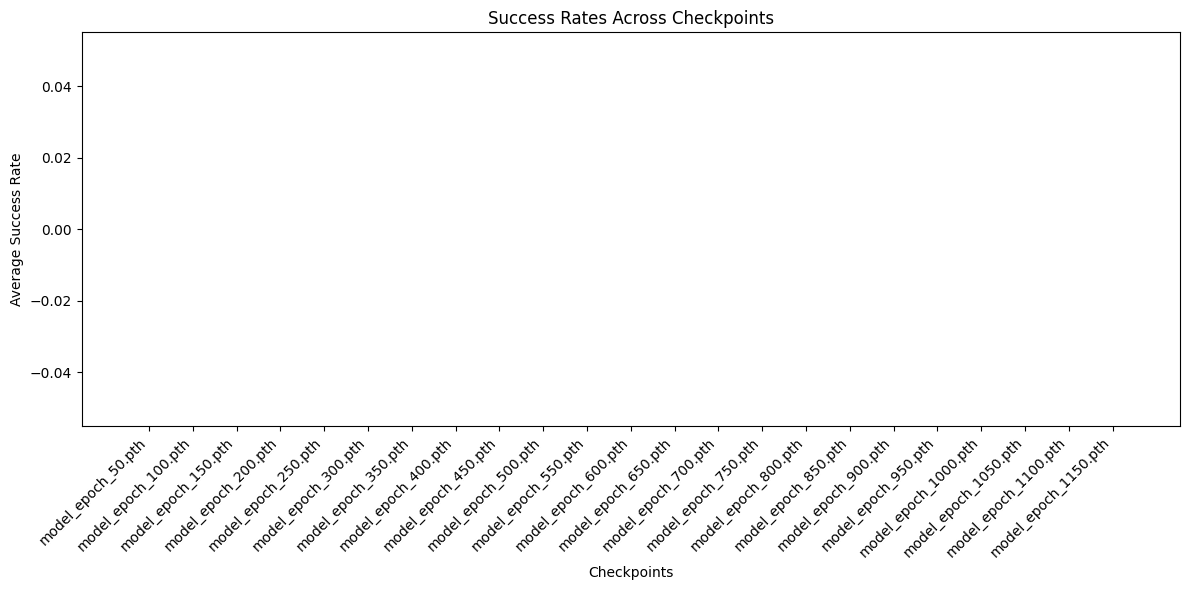

Success rates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [9]:
import torch


success_rates = []
checkpoint_names = []

for checkpoint_file in checkpoint_files:
    # Load the policy from the checkpoint
    policy.policy.deserialize(torch.load(checkpoint_file)["model"])
    policy.policy.set_eval()
    
    # Run multiple rollouts and collect stats
    num_rollouts = 10
    rollout_stats = []
    for _ in range(num_rollouts):
        stats = rollout(
            policy=policy, 
            env=env, 
            horizon=100, 
            render=False, 
            video_writer=None, 
            video_skip=5, 
            camera_names=["fixed_camera"]
        )
        rollout_stats.append(stats)
    
    # Calculate average success rate
    avg_success_rate = sum(stat['Success_Rate'] for stat in rollout_stats) / num_rollouts
    success_rates.append(avg_success_rate)
    checkpoint_names.append(os.path.basename(checkpoint_file))

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(checkpoint_names, success_rates)
plt.xlabel('Checkpoints')
plt.ylabel('Average Success Rate')
plt.title('Success Rates Across Checkpoints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Success rates:", success_rates)
